# Imbalanced classification
Author: [Ryan Parker](https://github.com/rparkr)  
Started: Feb 2024  
Adapted from the excellent Keras tutorial: [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/)

In this notebook, I follow along with the Keras tutorial to practice using Keras and to learn some techniques for working with highly imbalanced classification tasks.

I also train a GBM on the same data and compare its performance to the neural network, then I inspect the feature importance for both the GBM and the neural network using the `shap` library.

# Start here

In [1]:
# Built-in packages
import os

# Set the backend to use with Keras
os.environ["KERAS_BACKEND"] = "jax"

# External packages
import numpy as np
import pandas as pd
import keras

In [2]:
df = pd.read_csv('~/Downloads/creditcard.csv')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
targets = df["Class"].to_numpy(dtype="uint8")
features = df.drop(columns=["Class"]).to_numpy(dtype="float32")

## Create a validation set

In [13]:
rng = np.random.default_rng(seed=12)
VAL_SIZE = 0.2
VAL_START_INDEX = int(targets.shape[0] * VAL_SIZE)
shuffled_indices = rng.permutation(x=targets.shape[0])
val_indices = shuffled_indices[:VAL_START_INDEX]
train_indices = shuffled_indices[VAL_START_INDEX:]

train_features = features[train_indices, :]
val_features = features[val_indices, :]
train_targets = targets[train_indices]
val_targets = targets[val_indices]

print(f"Number of training samples: {len(train_targets)}")
print(f"Number of validation samples: {len(val_targets)}")

Number of training samples: 227846
Number of validation samples: 56961


## Analyze class imbalance

In [16]:
counts = np.bincount(train_targets)
print(
    f"There are {counts[1]:,.0f}/{train_targets.shape[0]:,.0f} positive samples"
    f" in the training data ({counts[1] / train_targets.shape[0]:,.2%})"
)

There are 396/227,846 positive samples in the training data (0.17%)


## Set weights for each class

In [22]:
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
print(f"Class 0 weight: {weight_for_0:,.8f}\nClass 1 weight: {weight_for_1:,.8f}")

Class 0 weight: 0.00000440
Class 1 weight: 0.00252525


## Normalize the data using training set statistics

In [23]:
mean = np.mean(train_features, axis=0)
# Subtract the mean
train_features -= mean
val_features -= mean
# Divide by the standard deviation
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std

## Build a binary classification model

In [28]:
model = keras.Sequential(
    [
        keras.Input(shape=train_features.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,777 (546.00 KB)

 Trainable params: 139,777 (546.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model with `class_weight` argument

In [29]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.keras")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)

Epoch 1/30
112/112 - 14s - 126ms/step - fn: 45.0000 - fp: 31951.0000 - loss: 2.6212e-06 - precision: 0.0109 - recall: 0.8864 - tn: 195499.0000 - tp: 351.0000 - val_fn: 4.0000 - val_fp: 4361.0000 - val_loss: 0.3341 - val_precision: 0.0207 - val_recall: 0.9583 - val_tn: 52504.0000 - val_tp: 92.0000
Epoch 2/30
112/112 - 9s - 84ms/step - fn: 40.0000 - fp: 7996.0000 - loss: 1.6291e-06 - precision: 0.0426 - recall: 0.8990 - tn: 219454.0000 - tp: 356.0000 - val_fn: 8.0000 - val_fp: 2801.0000 - val_loss: 0.1595 - val_precision: 0.0305 - val_recall: 0.9167 - val_tn: 54064.0000 - val_tp: 88.0000
Epoch 3/30
112/112 - 4s - 37ms/step - fn: 26.0000 - fp: 6398.0000 - loss: 1.1361e-06 - precision: 0.0547 - recall: 0.9343 - tn: 221052.0000 - tp: 370.0000 - val_fn: 8.0000 - val_fp: 1135.0000 - val_loss: 0.0670 - val_precision: 0.0720 - val_recall: 0.9167 - val_tn: 55730.0000 - val_tp: 88.0000
Epoch 4/30
112/112 - 4s - 37ms/step - fn: 22.0000 - fp: 6824.0000 - loss: 9.8003e-07 - precision: 0.0520 - recal

# Compare to a GBM

Binning 0.049 GB of training data: 3.279 s
Binning 0.005 GB of validation data: 0.112 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.60541, val loss: 0.60531, in 0.117s
[2/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.53310, val loss: 0.53067, in 0.138s
[3/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.47238, val loss: 0.46950, in 0.139s
[4/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.42113, val loss: 0.42091, in 0.110s
[5/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.37689, val loss: 0.37479, in 0.108s
[6/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.33858, val loss: 0.33709, in 0.110s
[7/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.30496, val loss: 0.30235, in 0.171s
[8/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.27513, val loss: 0.27262, in 0.140s
[9/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.24869, val loss: 0.24826, in 0.146s
[10/100] 1 tree, 31 leaves, max depth = 8, train

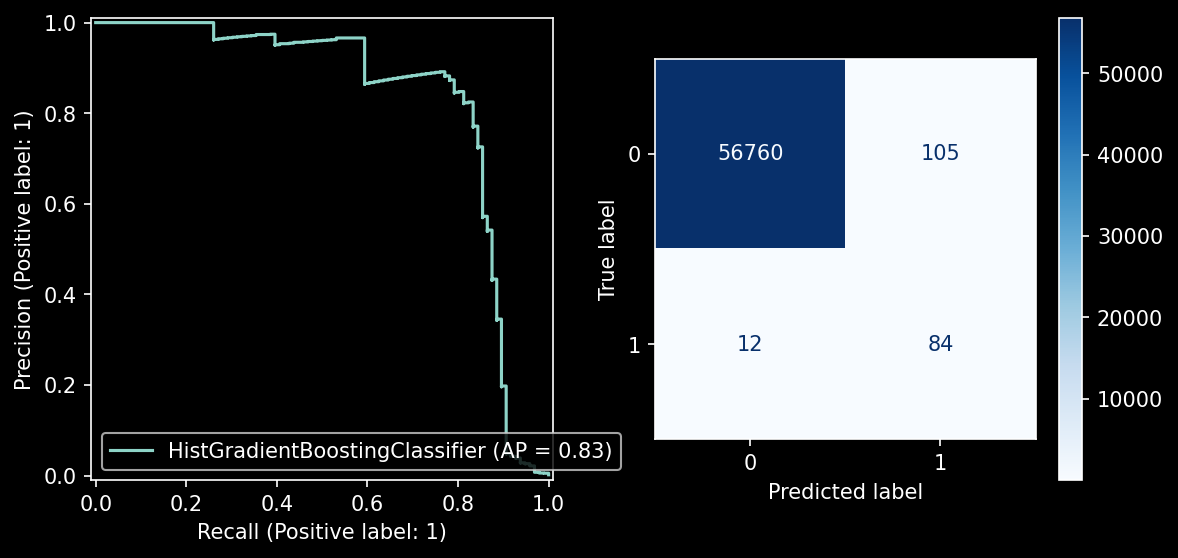

In [44]:
import matplotlib.pyplot as plt

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)

model_gbm = HistGradientBoostingClassifier(class_weight=class_weight, verbose=2)
model_gbm.fit(train_features, train_targets)

print(classification_report(val_targets, model_gbm.predict(val_features)))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=150)
PrecisionRecallDisplay.from_estimator(model_gbm, val_features, val_targets, ax=axs[0])
ConfusionMatrixDisplay.from_estimator(model_gbm, val_features, val_targets, cmap="Blues", ax=axs[1])
plt.show()

## Explain the models' predictions

First, the GBM:

 93%|=================== | 1858/2000 [00:13<00:00]       

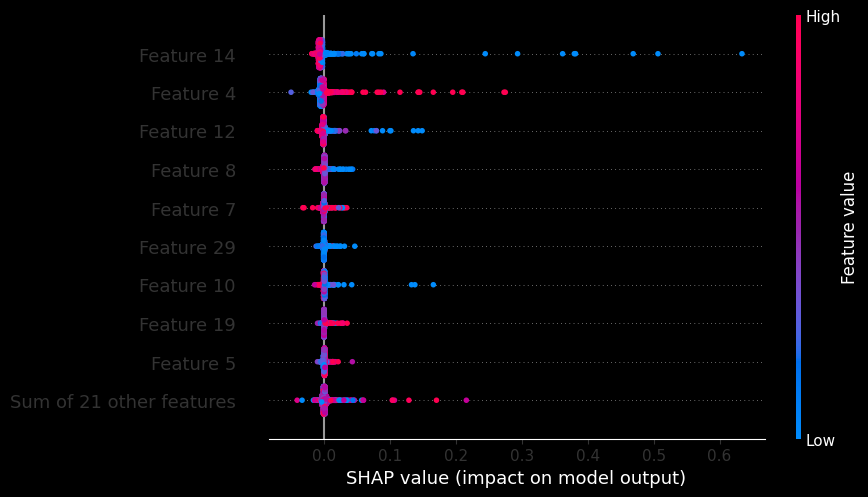

In [51]:
import shap

explainer = shap.TreeExplainer(
    model_gbm,
    shap.sample(train_features, 1000, random_state=12),
    model_output="probability",
)

shap_values = explainer(shap.sample(val_features, 2000, random_state=12))
shap.plots.beeswarm(shap_values, max_display=10)

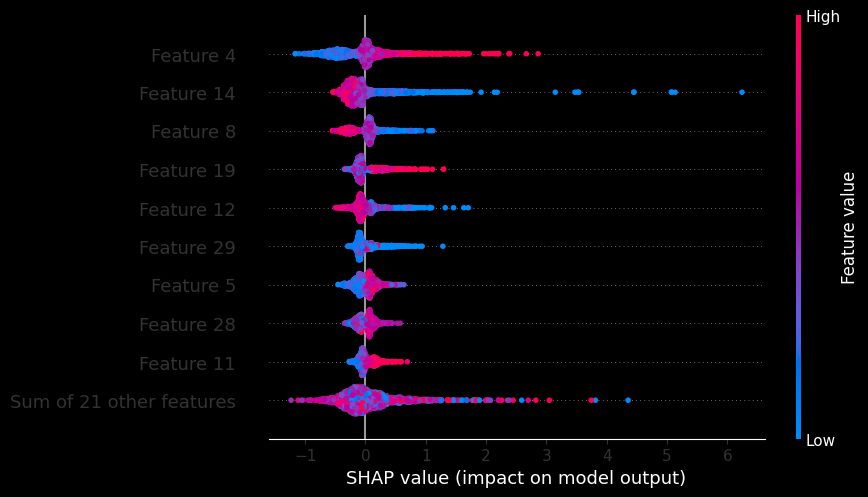

In [52]:
explainer = shap.TreeExplainer(model_gbm)

shap_values = explainer(shap.sample(val_features, 2000, random_state=12))
shap.plots.beeswarm(shap_values, max_display=10)

Explain the output of the neural network

PermutationExplainer explainer: 1001it [18:28,  1.12s/it]                          


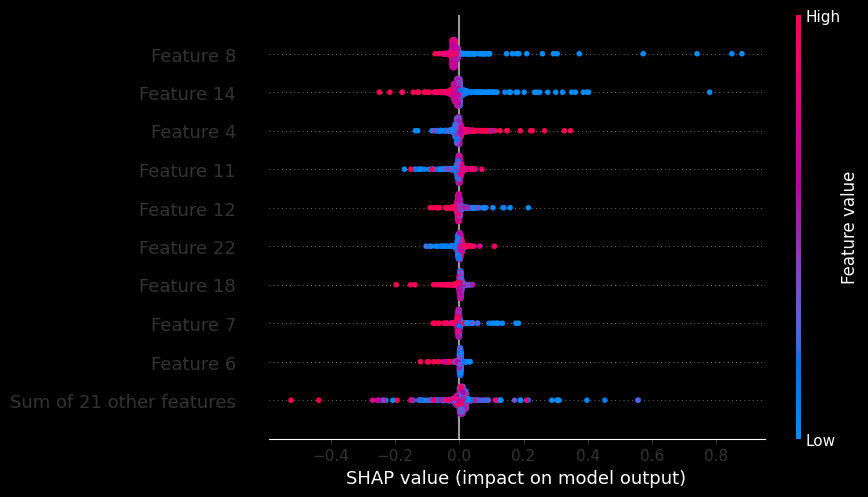

In [55]:
# This method takes a LONG time -- like 20 minutes

explainer = shap.Explainer(
    model,
    shap.sample(train_features, 1000, random_state=12),
    model_output="probability",
)

shap_values = explainer(shap.sample(val_features, 1000, random_state=12))
shap.plots.beeswarm(shap_values, max_display=10)

PermutationExplainer explainer: 1001it [20:45:26, 75.41s/it]                                


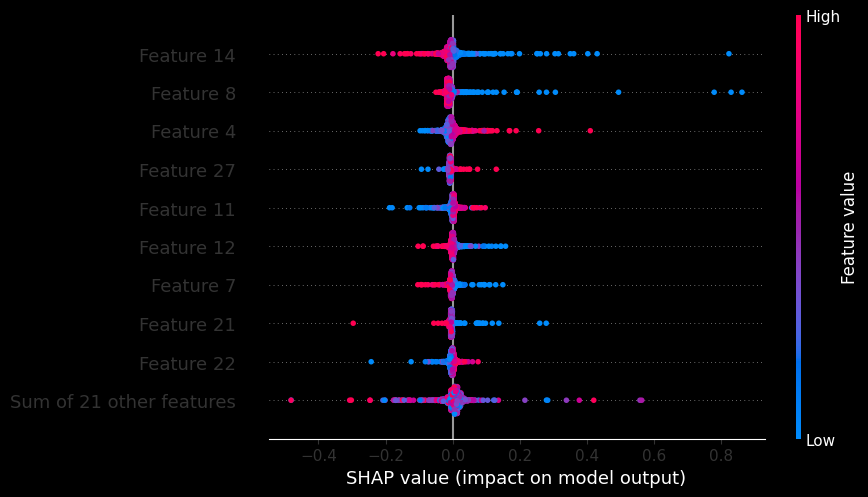

In [56]:
# This also takes a long time: about 15 minutes

explainer = shap.Explainer(model, shap.sample(train_features, 1000))

shap_values = explainer(shap.sample(val_features, 1000, random_state=12))
shap.plots.beeswarm(shap_values, max_display=10)

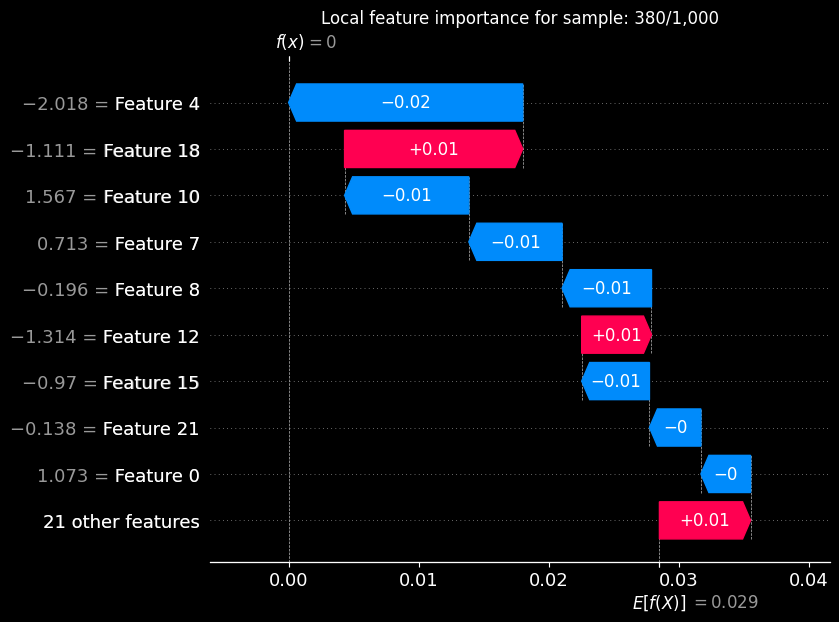

In [64]:
import random
chosen_index = random.randint(0, shap_values.shape[0] - 1)
shap.plots.waterfall(shap_values[chosen_index, :], show=False)
plt.title(f"Local feature importance for sample: {chosen_index:,.0f}/{shap_values.shape[0]:,.0f}")
plt.show()